In [222]:

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import re

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go  
import plotly.express as px

import datetime
%pip install scikit-learn xgboost category_encoders

plt.style.use('ggplot')

from scipy import stats


from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from category_encoders import MEstimateEncoder


Note: you may need to restart the kernel to use updated packages.


In [223]:
df = pd.read_csv('/Users/sumeet/Desktop/cuantum/HousePrices.csv')

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

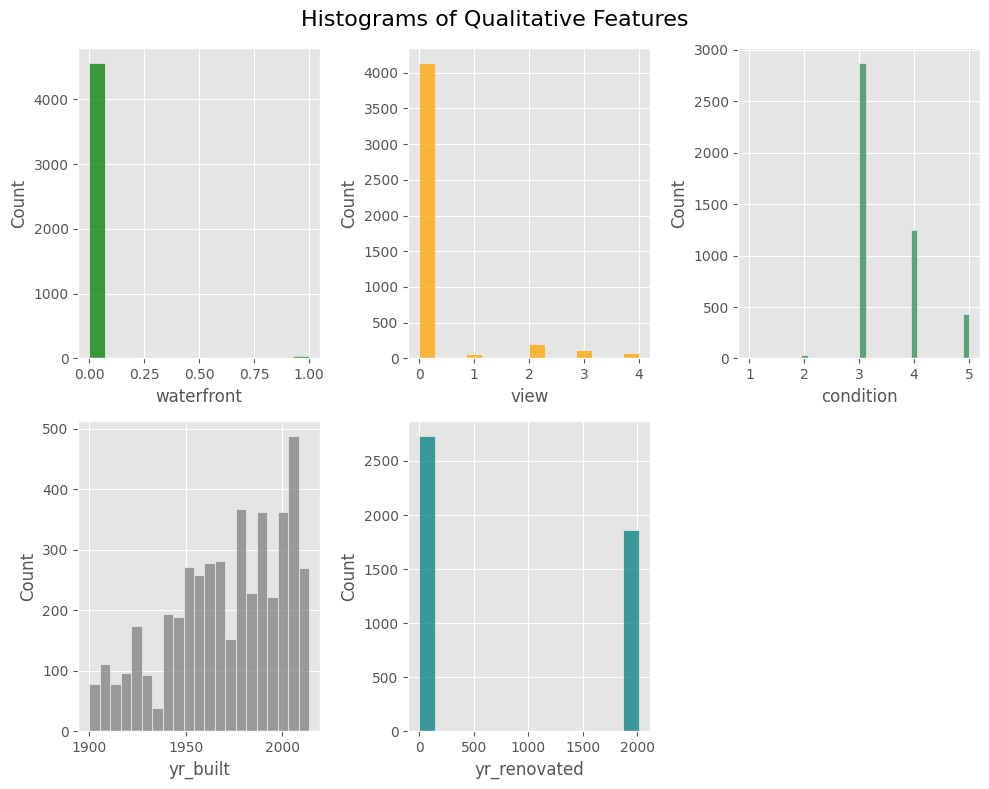

In [225]:
df['State'] = df['statezip'].str.extract(r'([A-Za-z]+)')

my_qual_cols = df[["waterfront", 'view', 'condition', 'yr_built', 'yr_renovated']]

my_colors = ('green', 'orange', 'seagreen', 'gray', 'teal')

# Adjust the number of subplots dynamically based on the number of columns
num_cols = len(my_qual_cols.columns)
num_rows = (num_cols + 2) // 3  # Calculate rows needed for 3 columns per row

fig, axes = plt.subplots(num_rows, 3, figsize=(10, 4 * num_rows))
axes = axes.flatten()

for i, col in enumerate(my_qual_cols.columns):
    sns.histplot(data=df, x=col, ax=axes[i], color=my_colors[i % len(my_colors)])  

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle('Histograms of Qualitative Features', fontsize=16)

plt.tight_layout()
plt.show()

In [226]:
df['statezip'].describe()

count         4600
unique          77
top       WA 98103
freq           148
Name: statezip, dtype: object

In [227]:
df['State'].unique()

array(['WA'], dtype=object)

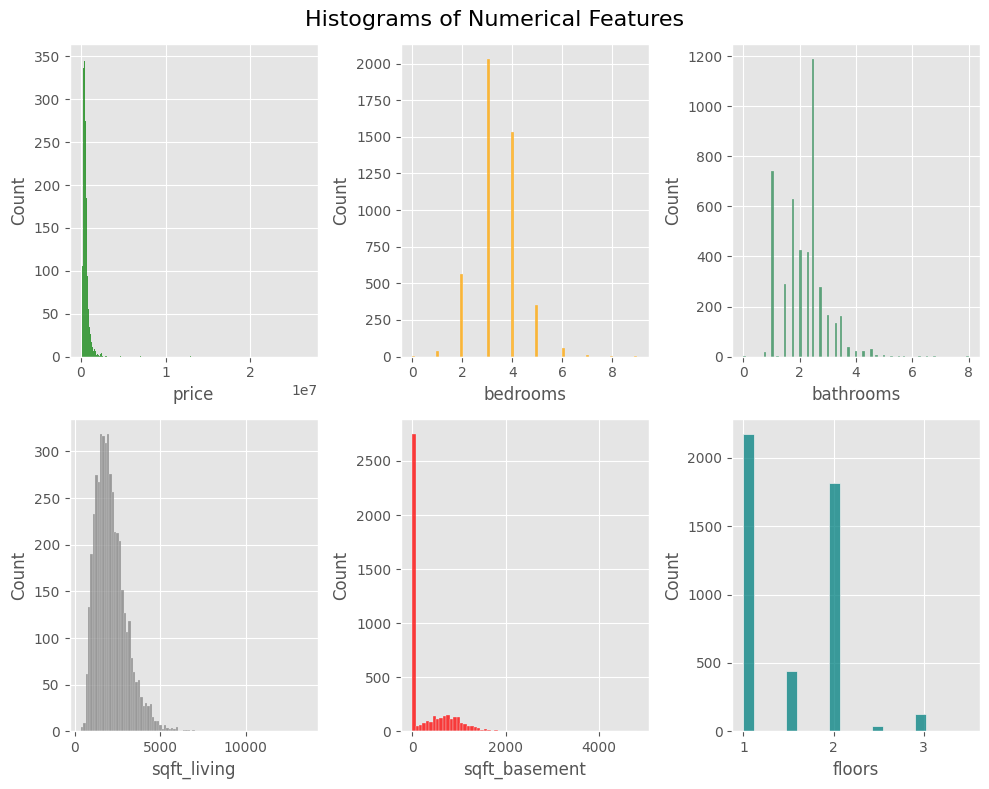

In [228]:

my_plot_cols = df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_basement', 'floors']]

my_colors = ('green', 'orange', 'seagreen', 'gray', 'red', 'teal')

# Adjust the number of subplots dynamically based on the number of columns
num_cols = len(my_plot_cols.columns)
num_rows = (num_cols + 2) // 3  # Calculate rows needed for 3 columns per row

fig, axes = plt.subplots(num_rows, 3, figsize=(10, 4 * num_rows))
axes = axes.flatten()

for i, col in enumerate(my_plot_cols.columns):
    sns.histplot(data=df, x=col, ax=axes[i], color=my_colors[i % len(my_colors)])  

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle('Histograms of Numerical Features', fontsize=16)

plt.tight_layout()
plt.show()

price            1.000000
sqft_living      0.430410
sqft_above       0.367570
bathrooms        0.327110
sqft_basement    0.210427
bedrooms         0.200336
floors           0.151461
sqft_lot         0.050451
yr_built         0.021857
yr_renovated    -0.028774
Name: price, dtype: float64


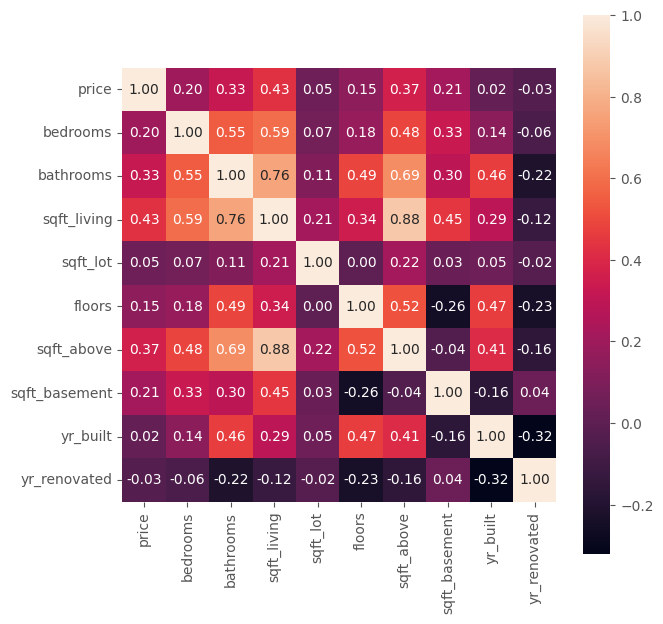

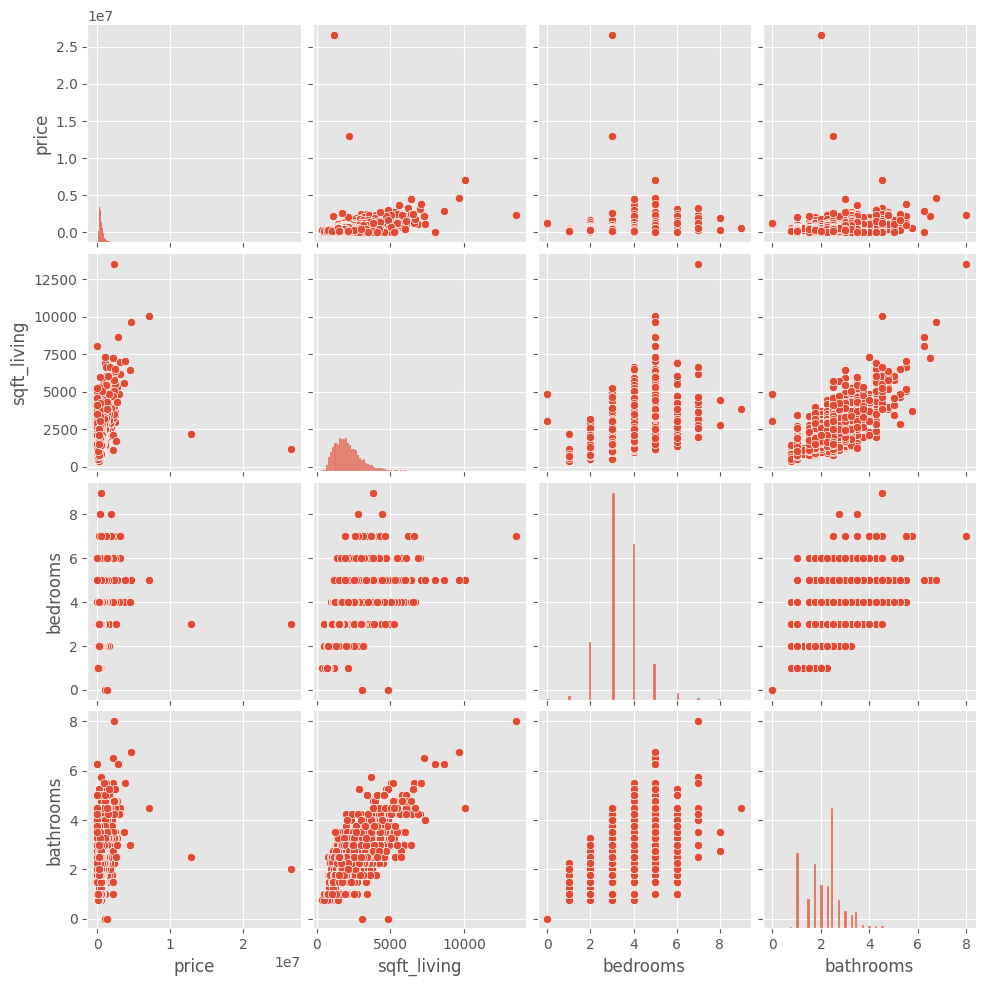

In [252]:
# Select only numeric columns for the heatmap
numeric_cols = df.select_dtypes(include=['number'])

# Drop unwanted columns
numeric_cols = numeric_cols.drop(columns=['view', 'condition', 'waterfront'], errors='ignore')

plt.figure(figsize=(7,7))

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Extract correlation of all variables with 'price'
price_correlation = correlation_matrix['price'].sort_values(ascending=False)
print(price_correlation)

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", square=True, )

# Pairplot for selected columns
sns.pairplot(df[['price', 'sqft_living', 'bedrooms', 'bathrooms']])

In [230]:
df.isin([0]).sum()


date                0
price              49
bedrooms            2
bathrooms           2
sqft_living         0
sqft_lot            0
floors              0
waterfront       4567
view             4140
condition           0
sqft_above          0
sqft_basement    2745
yr_built            0
yr_renovated     2735
street              0
city                0
statezip            0
country             0
State               0
dtype: int64

In [231]:
df[df.bedrooms == 0]


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,State
2365,2014-06-12 00:00:00,1095000.0,0.0,0.0,3064,4764,3.5,0,2,3,3064,0,1990,2009,814 E Howe St,Seattle,WA 98102,USA,WA
3209,2014-06-24 00:00:00,1295648.0,0.0,0.0,4810,28008,2.0,0,0,3,4810,0,1990,2009,20418 NE 64th Pl,Redmond,WA 98053,USA,WA


<b> 

<Axes: >

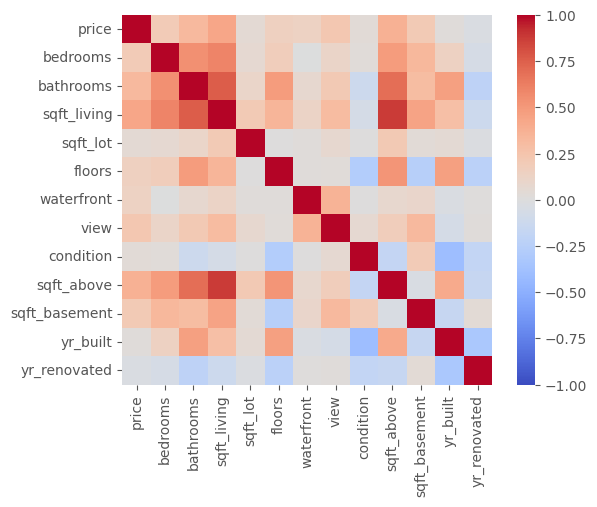

In [232]:
# Ensure all columns used in correlation are numeric
numeric_df = df.select_dtypes(include=['number'])

# Plot the heatmap
sns.heatmap(numeric_df.corr(), square=True, cmap='coolwarm', vmin=-1, vmax=1)


Text(0.5, 1.0, 'Barplot of Waterfront vs Price')

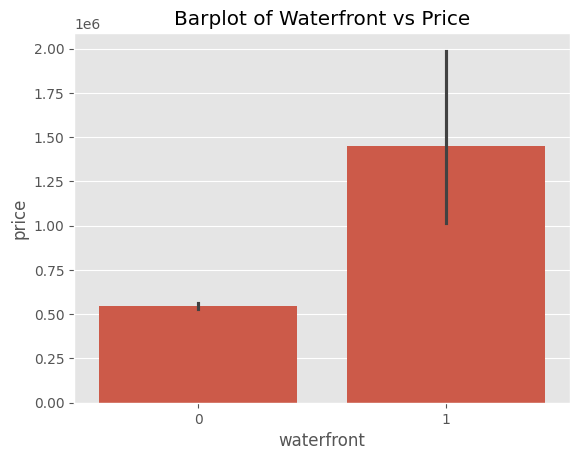

In [233]:
sns.barplot(x=df.waterfront, y=df.price)
plt.title("Barplot of Waterfront vs Price")

Text(0.5, 1.0, 'House Condition vs Price')

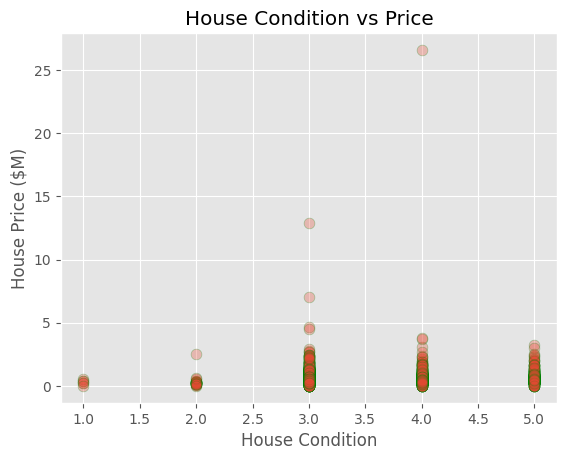

In [234]:
plt.scatter(df["condition"], df["price"].div(1000000), alpha = 0.3 ,s=60 , edgecolors='g')
plt.xlabel("House Condition")
plt.ylabel("House Price ($M)")
#plt.ylim((0, 5))
plt.title("House Condition vs Price")

Text(0.5, 1.0, 'Lineplot of Year Built vs Price')

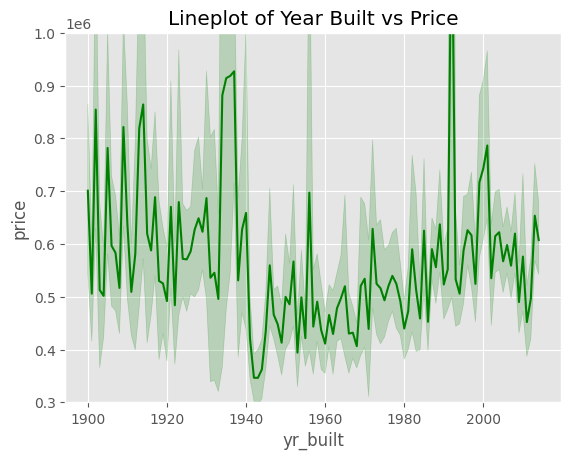

In [235]:
sns.lineplot(x='yr_built', y='price', data=df, color='g')
plt.ylim(300000, 1000000)
plt.title("Lineplot of Year Built vs Price")

<b>house prices are higher for old homes and newly constructed houses. Old houses could be priced higher due to their historical value.

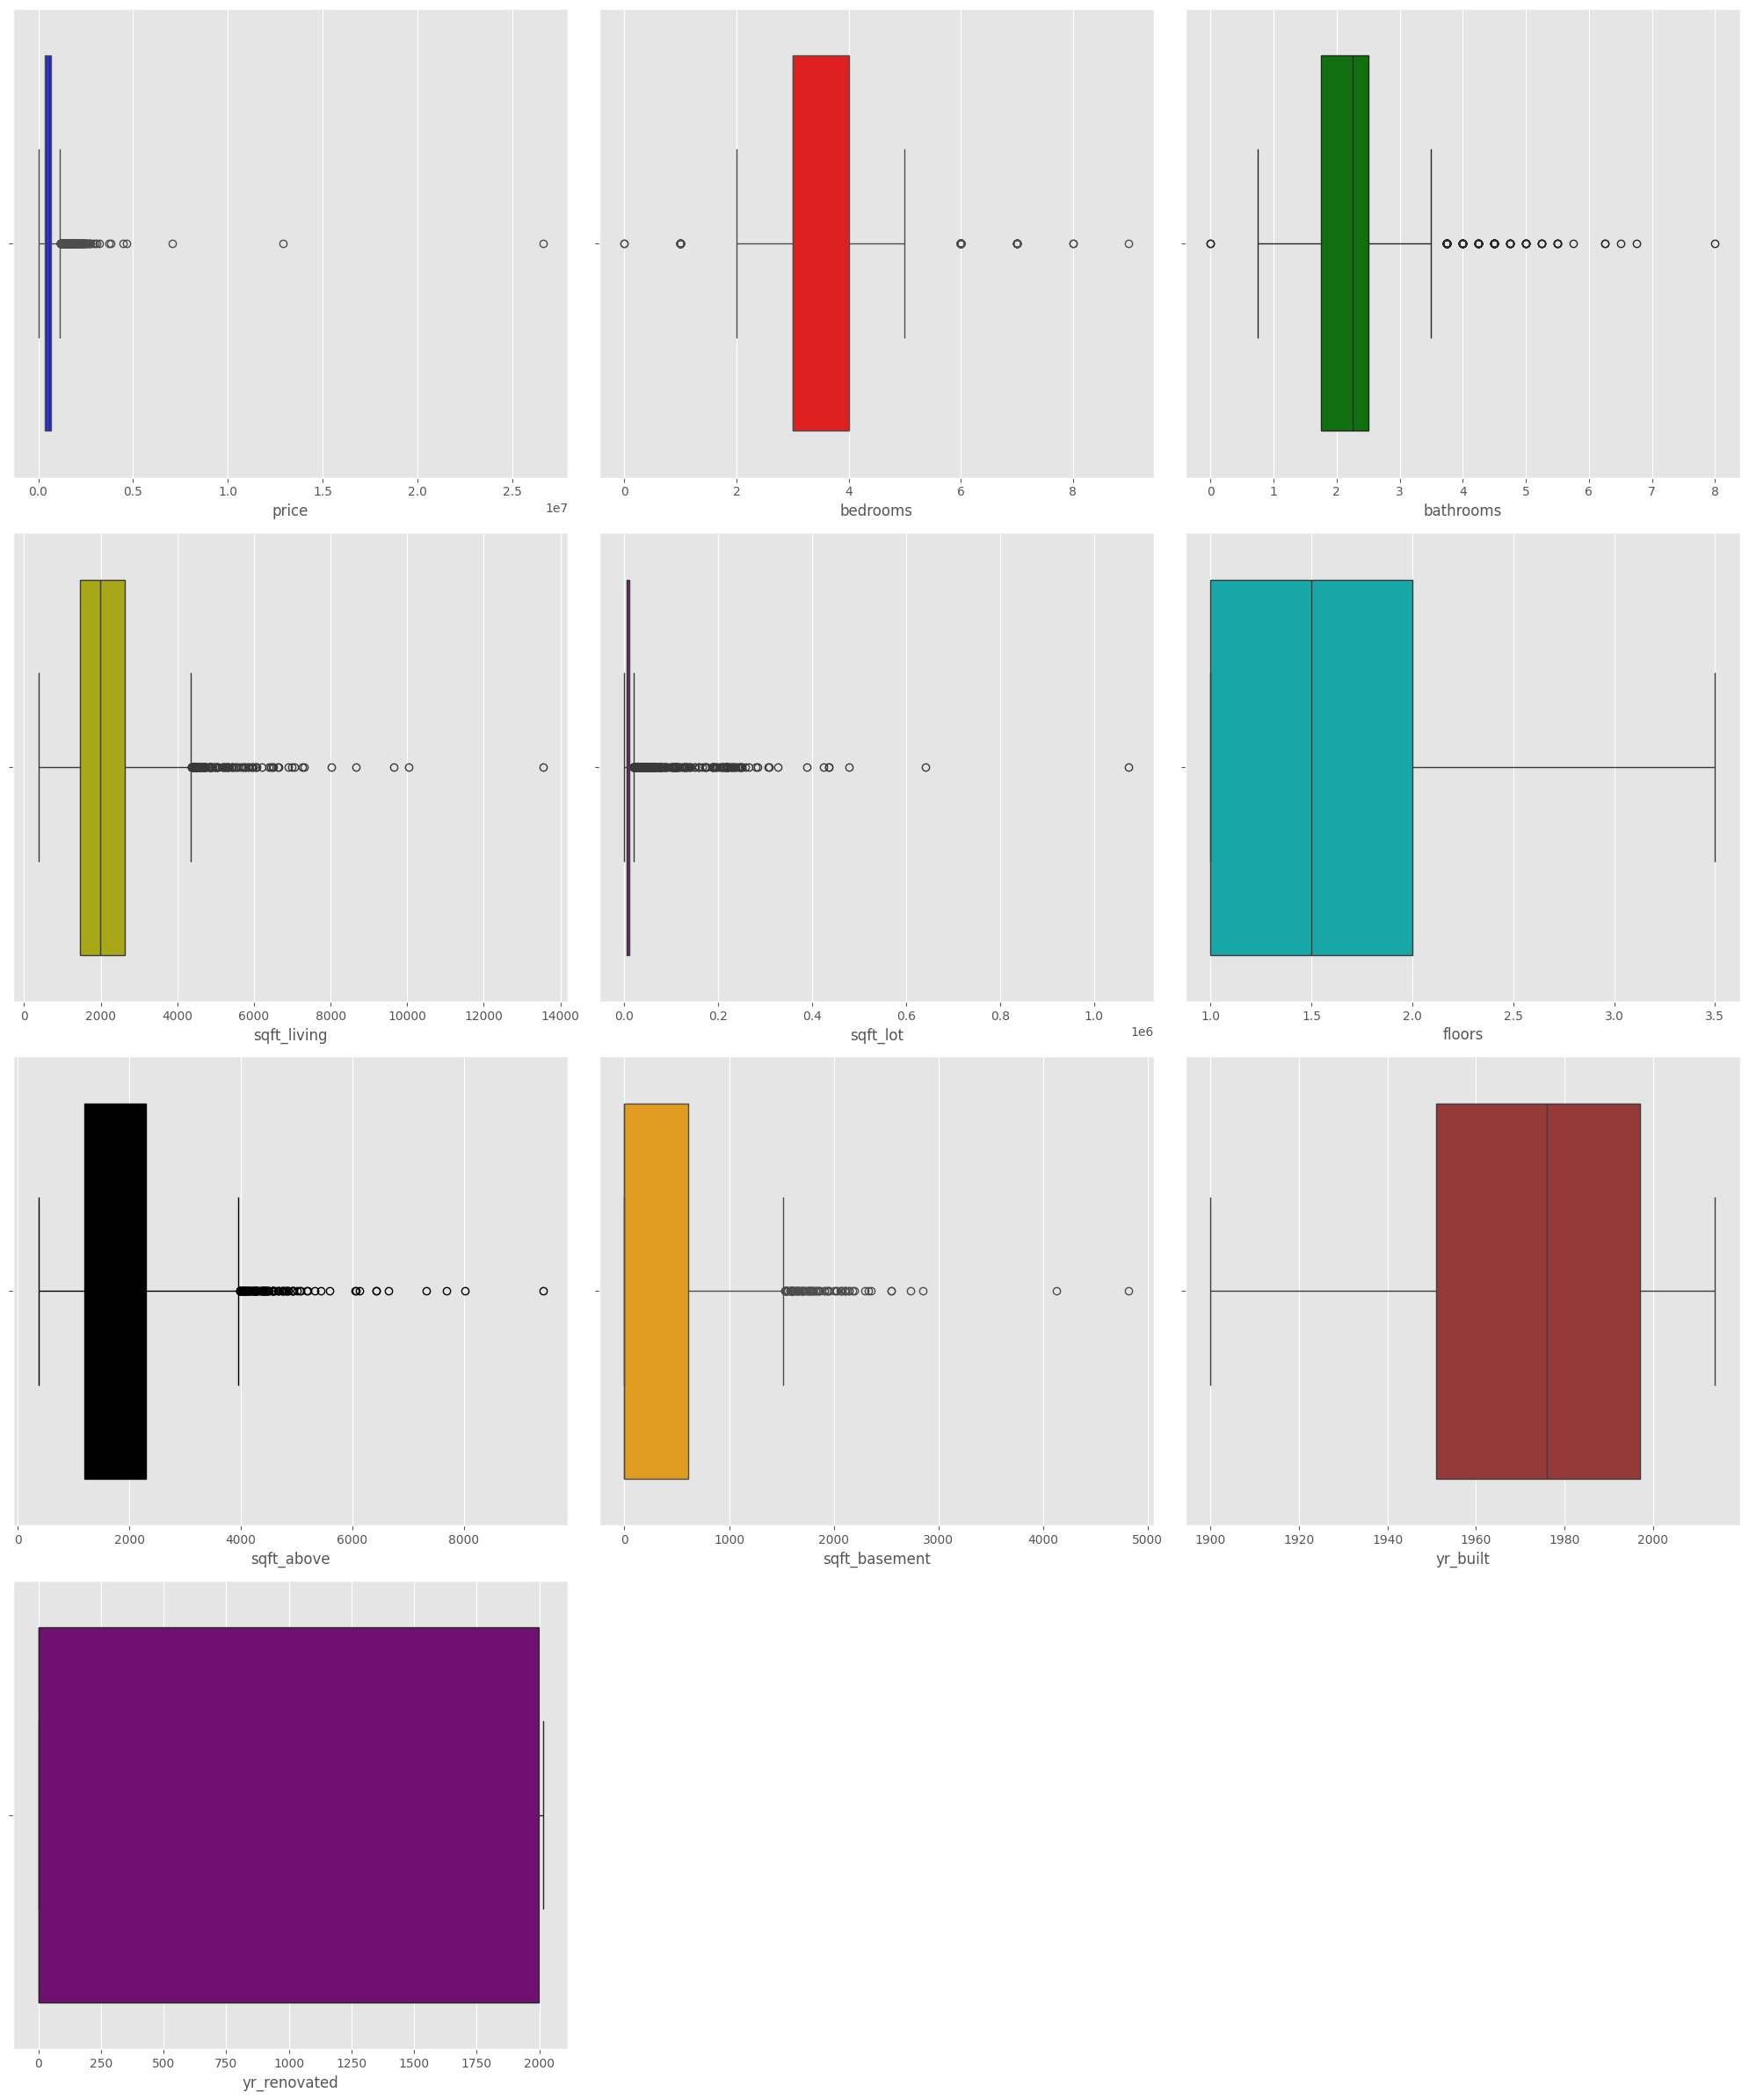

In [236]:
my_plot_cols = numeric_cols  
my_colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'orange', 'brown', 'purple', 'pink', 'gray']

fig, axes = plt.subplots(4, 3, figsize=(20, 24))

axes = axes.flatten()

# Ensure the loop does not exceed the number of available axes
for i, col in enumerate(my_plot_cols.columns[:len(axes)]):
    sns.boxplot(data=df, x=col, ax=axes[i], color=my_colors[i % len(my_colors)])

# Hide any unused axes
for j in range(len(my_plot_cols.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [237]:
count_above_500k = len(df[df['price'] > 5000000])
print(f"The number of houses priced above $500,0000 is {count_above_500k}")

outlier_bed = len(df[(df['bedrooms'] < 1) | (df['bedrooms'] > 7)])
print(f'The number of houses with outlier number of bedrooms is {outlier_bed}')

outlier_bath = len(df[(df['bathrooms'] < 1) | (df['bathrooms'] > 6)])
print(f'The number of houses with outlier number of bathrooms is {outlier_bath}')

outlier_sqt = len(df[(df['sqft_living'] > 8000) ])
print(f'The number of houses with outlier sqft is {outlier_sqt}')

outlier_lot = len(df[(df['sqft_lot'] > 500000) ])
print(f'The number of houses with outlier lot is {outlier_lot}')

outlier_sqtabove = len(df[(df['sqft_above'] > 7000) ])
print(f'The number of houses with outlier sqft_above is {outlier_sqtabove}')

outlier_basement = len(df[(df['sqft_basement'] > 2700) ])
print(f'The number of houses with outlier basement is {outlier_basement}')


The number of houses priced above $500,0000 is 3
The number of houses with outlier number of bedrooms is 5
The number of houses with outlier number of bathrooms is 24
The number of houses with outlier sqft is 5
The number of houses with outlier lot is 2
The number of houses with outlier sqft_above is 4
The number of houses with outlier basement is 4


In [238]:
df.shape

(4600, 19)

In [239]:
df_cleaned = df[
    ~ (
    (df['price'] > 5000000) |
    (df['bedrooms'] < 1) | (df['bedrooms'] > 7) |
    (df['bathrooms'] < 1) | (df['bathrooms'] > 6) |
    (df['sqft_living'] > 8000) |
    (df['sqft_lot'] > 500000) |
    (df['sqft_above'] > 7000) |
    (df['sqft_basement'] > 2700)
    )
]

df_cleaned.shape

(4565, 19)

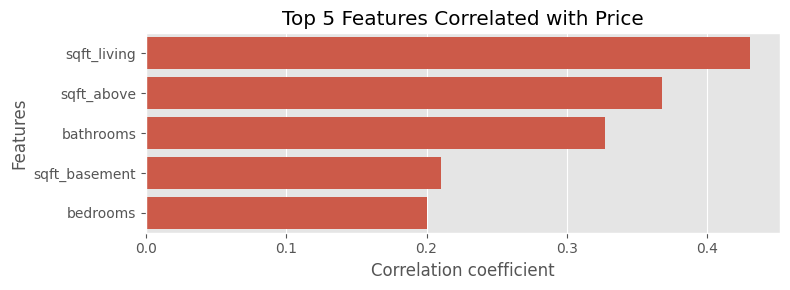

In [240]:
# Barplot of top correlated variables
top_corr = price_correlation[1:6]  # exclude 'price' itself, include top 5 others

plt.figure(figsize=(8, 3))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top 5 Features Correlated with Price')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [241]:
categorical_vars = ['view', 'waterfront', 'condition']

for var in categorical_vars:
    means = df.groupby(var)['price'].mean().sort_values()
    print(f"\nAverage price by {var}:")
    print(means)


Average price by view:
view
0    5.106849e+05
2    8.089353e+05
1    8.670110e+05
3    9.982075e+05
4    1.190667e+06
Name: price, dtype: float64

Average price by waterfront:
waterfront
0    5.454623e+05
1    1.451621e+06
Name: price, dtype: float64

Average price by condition:
condition
1    306633.333333
2    324373.750000
4    533647.286072
3    550111.516394
5    637041.322258
Name: price, dtype: float64


In [242]:

categorical_vars = ['view', 'waterfront', 'condition']

for var in categorical_vars:
    groups = [df[df[var] == level]['price'] for level in df[var].unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"{var}: F = {f_stat:.2f}, p = {p_val:.4f}")

view: F = 65.70, p = 0.0000
waterfront: F = 86.19, p = 0.0000
condition: F = 4.41, p = 0.0015


In [243]:
#Encoding of categorical variables

# Define X as the feature matrix (excluding the target variable 'price')
X = df.drop(columns=['price'])

# Apply one-hot encoding to categorical variables
X = pd.get_dummies(X, columns=['view', 'waterfront', 'condition'], drop_first=True)


In [244]:
(df.sqft_living == df.sqft_above + df.sqft_basement).all()


np.True_

<b> <i> ECDFs to compare how prices are distributed over May, June, and July—great for spotting shifts or spread differences over time.

In [245]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)

    x = np.sort(data)

    y = np.arange(1, n+1) / n

    return x, y

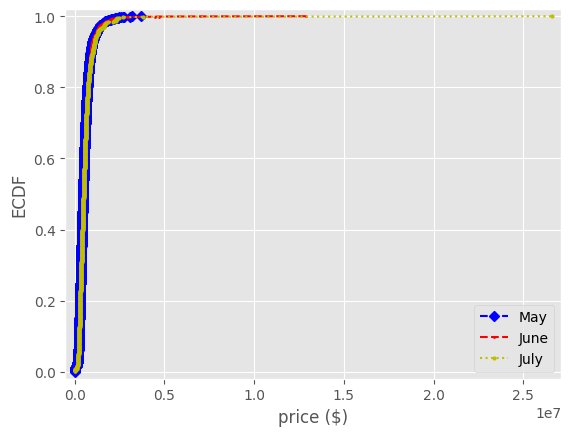

In [246]:
# Extract the month from the date column
df['Month'] = pd.to_datetime(df['date']).dt.strftime('%B')

# Compute ECDFs
x_5, y_5 = ecdf(df[df['Month'] == 'May']['price'])
x_6, y_6 = ecdf(df[df['Month'] == 'June']['price'])
x_7, y_7 = ecdf(df[df['Month'] == 'July']['price'])

# Plot the ECDFs
_ = plt.plot(x_5, y_5, marker='D', linestyle='--', markersize=5, c='b')
_ = plt.plot(x_6, y_6, marker='^', linestyle='--', markersize=1, c='r')
_ = plt.plot(x_7, y_7, marker='o', linestyle=':', markersize=2, c='y')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('price ($)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('May', 'June', 'July'), loc='lower right')

# Show the plot
plt.show()

since Sqft living = above + basement 

<b>drop sqft_living for models to avoid multicollinearity. 

In [247]:
#spilt into training and test group

# Define features and target
features = ['sqft_basement', 'sqft_above', 'bathrooms', 'view', 'waterfront', 'condition']

X = df[features]
y = df['price']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [248]:

model = LinearRegression()

model.fit(X_train, y_train)
preds = model.predict(X_test)

# Calculate RMSE manually if 'squared' argument is not supported
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


RMSE: 993346.51
R² Score: 0.03


In [249]:
model3 = RandomForestRegressor(n_estimators=100, random_state=42)

model3.fit(X_train, y_train)
preds = model.predict(X_test)

# Calculate RMSE manually if 'squared' argument is not supported
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 993346.51
R² Score: 0.03


In [250]:


# Features and target
features = ['sqft_basement', 'sqft_above', 'bathrooms', 'view', 'waterfront', 'condition', 'street', 'statezip', 'city']
X = df_cleaned[features]
y = df_cleaned['price']

# One-hot encode categorical variables if needed
X = pd.get_dummies(X, columns=['view', 'waterfront', 'condition'], drop_first=True)

# Encode high-cardinality categorical features
encoder = MEstimateEncoder(cols=['street', 'statezip', 'city'], m=0.5)
X_encoded = encoder.fit_transform(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


# Models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    
}

# Loop through models and evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "RMSE": rmse, "R²": r2})

# Results as DataFrame
results_df_cleaned = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df_cleaned)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.419e+12, tolerance: 4.176e+10
  model = cd_fast.enet_coordinate_descent(


               Model          RMSE        R²
1   Ridge Regression  55842.963431  0.977456
2   Lasso Regression  55852.358385  0.977448
0  Linear Regression  55852.774444  0.977448
3      Random Forest  79141.145516  0.954720


Linear Regression
baseline model that assumes a linear relationship between features and the target (price). 
It tries to fit a straight line (or hyperplane) through the data by minimizing the squared differences between predicted and actual values.

Ridge - A regularized version of Linear Regression (a.k.a. L2 regularization). penalizes large coefficients, helping to prevent overfitting and multicollinearity.
(The strength of regularization. Higher alpha = more shrinkage = more conservative model. alpha=0 becomes standard linear regression.)

Lasso - Also a regularized linear model — but this time with L1 regularization. Like Ridge, but Lasso can shrink some coefficients to exactly zero, essentially performing feature selection. alpha=0.1 Controls the strength of regularization. Larger alpha = stronger penalty = more coefficients set to zero.

Random Forest - An ensemble model that builds multiple decision trees and averages their predictions. It reduces overfitting of individual trees while keeping high predictive power. n_estimators=100: Builds 100 decision trees. More trees = better stability (to a point), but slower training. random_state=42:
For reproducibility. It ensures the random sampling and splits are the same every time you run it.



